# Obtaining structured web content and programmatic access

In this notebook we will learn how to make use of readily structured data through dedicated application programming interfaces (APIs), how to authenticate and how to properly design requests (also called "payload") in order to retrieve large datasets.

**Advantages** of APIs are that
- access is legal and in most cases clearly and transparently regulated (e.g. 10,000 calls per day)
- structuring through `requests` and `BeautifulSoup` not required
- Python packages that simplify server-client interaction are available

**Disadvantages** of APIs are that
- we have to learn how APIs work and how we should interact with them (each API has some peculiarities and documentation is usually good, but sometimes not so...)
- authentification may be required and access may not be free of charge 

We will
- obtain data of a public statistical office such as the IMF or World Bank through the `pandas-datareader`
- directly obtain a (ranking) table from a website such the [World Cube Association](https://www.worldcubeassociation.org/results/rankings/333/single)
- learn how to use the Destatis/GENESIS Online service and API
- learn how to use the Twitter API (in particular [Tweepy](https://www.tweepy.org/), a Python library for the Twitter API) and retrieve Tweets with GeoTags (i.e. coordinates) subject to specified geography and search terms
- conduct some small analyses and visualise the results appropriately

In [1]:
import pandas as pd

In [ ]:
!pip install pandas-datareader --upgrade

In [ ]:
from pandas_datareader import wb # imports world bank access
search = wb.search('GDP.*current.*US') # search for keyword
search

In [ ]:
df = wb.download(indicator = 'NY.GDP.MKTP.CD', country = ['DE', 'FR', 'IT'],
                start = 2000, end = 2019)
df.info()

In [ ]:
df.groupby('country').describe()

In [ ]:
df2 = df.reset_index()
df2.head()

In [ ]:
df2.info()

In [ ]:
df2.columns = ['country', 'year', 'gdp'] # rename columns
df2.year = df2.year.astype(int) # numeric annual indicator
df2.info()

In [19]:
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [ ]:
# set(df2['country'])

In [ ]:
traces = []

for country in df2['country'].unique():
    
    trace = go.Scatter(name = country, x = df2[df2['country'] == country]['year'],
                      y = df2[df2['country'] == country]['gdp'])
    
    traces.append(trace)
    
fig = go.Figure(data = traces)

fig.layout.update(title=go.layout.Title(

    text = 'Nominal GDP'

))

fig.layout.update(yaxis= go.layout.YAxis(title=go.layout.yaxis.Title(
                        text='in US$')));

fig.layout.update(xaxis = go.layout.XAxis(title = go.layout.xaxis.Title(text = 'Year'), rangeslider = dict(visible = True)));

iplot(fig, filename = 'Nominal_GDP')

## Directly parsing `table` objects from HTML

In [ ]:
ranking = pd.read_html('https://www.worldcubeassociation.org/results/rankings/333/single', encoding='utf-8')

In [ ]:
ranking[0].head()

Which nationality appears most frequently in the World Cube Association's ranking?

In [ ]:
ranking[0].groupby('Citizen of').count()

Which nationality needed, on average, the **lowest** amount of time to solve a 3x3x3 cube? Sort the output in ascending order.

In [ ]:
ranking[0].groupby('Citizen of').mean()['Result'].sort_values(ascending = True)

How many possible states/permutations, starting from the solved state, can a 3x3x3 Rubik's cube have? 

Hints:
1. The centre squares are fixed (a plane rotation around these squares doesn't change the cube's state)
2. There are eight corner pieces (with three colors on the side) and twelve edge pieces (with two colors on the side) which all revolve around the centre pieces
3. There are six different colors
4. We only look at "legal" states, i.e. those that can only be realised without assembling the cube (and therefore not violating Hint 1)

In [ ]:
import math

answer = (math.factorial(8) * 3**8) * 1/3 * (math.factorial(12) * 2**12) * 1/2 * 1/2

# [(corner pieces) * fraction of admissible corner combinations (clock-wise and anti-clockwise twists cancel each other out, 
# hence 3**7 / 3**8 = 1/3)] 
# * [(edge pieces) * fraction of admissible edge combinations (clock-wise and anti-clockwise twists cancel each other out, 
# hence 2**11 / 2**12 = 1/2)]
# * [1/2 (only half of the corner and edge states can be reached as corner and edge states must both coincide in the number
# i.e. even or odd of turns taken to reach either position)]

print(str(answer) + " or about 43.2 quintillion combinations!")

Which result entry in the World Ranking table is the most recent one? Which one is the oldest one? Be as precise as possible! (Hint: You may have to combine your knowledge from scraping HTML files.)

Compute the expected value of `Result` conditional on `Nationality = 'Germany'`. Are the German contestants statistically significantly faster/slower in solving the cube than other contestants, based on `Nationality`? Does statistical significance change if you use robust standard errors?

In [ ]:
!pip install statsmodels

In [ ]:
import statsmodels.api as sm

In [ ]:
df = ranking[0]
df['Non_German_Dummy'] = 1

In [ ]:
non_german_index = df[df['Citizen of'] != 'Germany'].index

In [ ]:
german_index = [x for x in df.index if x not in non_german_index]

In [ ]:
dummy_values = [0 if y in german_index else 1 for y in df.index]

In [ ]:
X = dummy_values
Y = df['Result']

X = sm.add_constant(X) # adding a constant
model = sm.OLS(Y, X).fit()
print_model = model.summary()
print(print_model)

In [ ]:
model.get_robustcov_results(cov_type='HC1').summary()

## Spatial libraries

The installation procedure of spatial libraries for Python (on Windows) can be quite tedious but [this answer](https://stackoverflow.com/questions/51095970/install-python-geopandas-failed/51560940#51560940) on Stackoverflow (make sure to upvote ;)) and [this detailed instruction](https://geoffboeing.com/2014/09/using-geopandas-windows/) make it straight forward. You can also find the required wheels for Python 3.8 and 64-bit for offline `pip install` in this notebook's [repository](https://github.com/gerwolf/webscraping-workshop/tree/main/DataFrames%20and%20APIs). After this, you can simply `pip install geopandas`.

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16,9]

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [ ]:
world.plot()

In [ ]:
world.head()

In [ ]:
df = pd.read_csv("https://gist.githubusercontent.com/gerwolf/81ebb170eb25d4a13f2695db4520f90e/raw/7c24eb4a2b11f6d4c7ac38bdf3555dfc7da6823e/GDPpc_PPP.csv", sep = ";")
df['Country'] = df['Country'].str.replace('�',' ')
df['Country'] = df['Country'].str.replace('United States','United States of America')

In [ ]:
df[df['Country'] == 'United States of America']

In [ ]:
final_geodf = df.merge(world, left_on='Country', right_on = 'name', how = 'left').dropna()

In [ ]:
final_geodf['GDPpc_PPP'] = final_geodf['GDPpc_PPP'].str.replace(',','')

In [ ]:
fig = go.Figure(data=[go.Choropleth(
    locations=final_geodf['iso_a3'], # Spatial coordinates
    z = final_geodf['GDPpc_PPP'].astype(float), # Data to be color-coded
#     locationmode = 'world', # set of locations match entries in `locations`
    colorscale = 'Reds',
    text=final_geodf['Country']
#     colorbar_title = "Millions USD",
)])

fig.layout.update(
    title_text = 'GDP per capita (2018, IMF)',
    geo_scope='world', # limite map scope to USA
);

iplot(fig, filename ="geomap")

In [ ]:
fig = go.Figure(data=[go.Choropleth(
    locations=final_geodf[final_geodf['continent'] == 'Europe']['iso_a3'], # Spatial coordinates
    z = final_geodf[final_geodf['continent'] == 'Europe']['GDPpc_PPP'].astype(float), # Data to be color-coded
#     locationmode = 'world', # set of locations match entries in `locations`
    colorscale = 'Reds',
    text=final_geodf[final_geodf['continent'] == 'Europe']['Country']
#     colorbar_title = "Millions USD",
)])

fig.layout.update(
    title_text = 'GDP per capita (2018, IMF)',
    geo_scope='europe', # limite map scope to USA
);

iplot(fig, filename ="geomap")

## Destatis/GENESIS Online
The GENESIS API is the web interface service by the Federal Statistical Office of Germany and is a good place to start learning how to interact programmatically with a server.

There is a [comprehensive description/introduction](https://www-genesis.destatis.de/genesis/misc/GENESIS-Webservices_Einfuehrung.pdf) on the service, unfortunately in German only. To display the PDF inside Jupyter Notebook in Chrome you may have to enable the [PDF Viewer extension](https://chrome.google.com/webstore/detail/pdf-viewer/oemmndcbldboiebfnladdacbdfmadadm?utm_source=chrome-ntp-icon).

In [ ]:
from IPython.display import IFrame, display
filepath = "https://www-genesis.destatis.de/genesis/misc/GENESIS-Webservices_Einfuehrung.pdf"
IFrame(filepath, width=980, height=800)

Read about the `whoami` method (in Section 2.2). Do you have to authenticate? What does it return? How would you send a `request`?

In [ ]:
import genesis_config
import requests

In [ ]:
url = "https://www-genesis.destatis.de/genesisWS/rest/2020/helloworld/whoami"
response = requests.get(url)
response.text

Read about the `logincheck` method (in Section 2.2). Do you have to authenticate? What does it return? Construct a request object using string formatting, send a `request` (in English language) and print the request's status. What type is the response's `text` attribute?

In [ ]:
url = 'https://www-genesis.destatis.de/genesisWS/rest/2020/helloworld/logincheck?username={}&password={}&language={}'.format(genesis_config.Username, genesis_config.Password, 'en')
response = requests.get(url)

In [ ]:
print(response.text)

Now that we have a working connection to the GENESIS Online API we want to directly obtain an economic indicator, the private sector's savings rate on a quarterly basis, for instance. This `data` is usually stored in a `table` somewhere in the depths of a data warehouse and it is (unfortunately) necessary to familiarise yourself, at least partially, with the internal server's structure.
1. In the documentation file search for the `tablefile` method (under Section 2.5 Data). When should it be used? What does it return?
2. Which method should you use if you want to directly obtain a `chart`?
3. Which method should you use if you want to directly obtain a regional `map`? Which parameter controls the image's resolution?

In [ ]:
field = '12411-0010'
stand = '31.12.2019'
language = 'en'
url = 'https://www-genesis.destatis.de/genesisWS/rest/2020/data/map2table?username={}&password={}&name={}&area=all&mapType=0&classes=5&classification=0&zoom=3&startyear=&endyear=&timeslices=&regionalvariable=&regionalkey=&classifyingvariable1=&classifyingkey1=&classifyingvariable2=&classifyingkey2=&classifyingvariable3=&classifyingkey3=&format=png&stand={}&language={}'.format(genesis_config.Username, genesis_config.Password, field, stand, language)
response = requests.get(url)

In [ ]:
with open("map.png", 'wb') as f:
    f.write(response.content)

In [ ]:
from IPython.display import Image
Image(filename='map.png') 

4. Login to the [GENESIS Online user interface](https://www-genesis.destatis.de/genesis/online?Menu=Anmeldung#abreadcrumb). Familiarise yourself with the tables' structure and navigate to the National Accounts (at the central level) --> Private sector disposable income and savings at quarterly frequency. Which parameters in the request can you control?
5. Which method would you choose if you want to directly obtain a `table` in some machine readable format, e.g. a `.csv` or `.xlsx` that you can read into `pandas`? How do you include additional conditions matching particular values?
6. Construct a `request` which contains the following specification:
    - only seasonally and calendar-adjusted values (X13)
    - all available years and quarters
    - output format should be a `.xlsx` file
7. Send the request but directly through the `pandas.read_excel()` method.

In [ ]:
! pip install openpyxl

In [ ]:
code = '81000-0010'
key_1 = 'WERT04'
val_1 = 'X13JDKSB'
key_2 = ''
val_2 = ''
key_3 = ''
val_3 = ''
start_year = '1991'
end_year = '2020'

url = ('https://www-genesis.destatis.de/genesisWS/rest/2020/data/tablefile?username={}&password={}&name={}&area=DINSG*&compress=false&transpose=false&startyear={}&endyear={}&timeslices=&regionalvariable=&regionalkey=&classifyingvariable1={}&classifyingkey1={}&classifyingvariable2={}&classifyingkey2={}&classifyingvariable3={}&classifyingkey3={}&format=xlsx&job=false&stand=&language=de').format(genesis_config.Username, genesis_config.Password, code, start_year, end_year, key_1, val_1, key_2, val_2, key_3, val_3)
df = pd.read_excel(url)

In [ ]:
df

In [3]:
import numpy as np

In [ ]:
df = df.iloc[[2,3,37], :].T.iloc[2:,:]
df.columns = ['Year', 'Quarter', 'Rate']
df.reset_index(inplace = True, drop = True)
df['Year'] = df['Year'].fillna(method='ffill')
df['Quarter_str'] = df['Quarter'].copy()
df['Quarter'] = df['Quarter'].replace('1. Quartal', 'Q1')
df['Quarter'] = df['Quarter'].replace('2. Quartal', 'Q2')
df['Quarter'] = df['Quarter'].replace('3. Quartal', 'Q3')
df['Quarter'] = df['Quarter'].replace('4. Quartal', 'Q4')
df['Rate'] = df['Rate'].replace ('...', np.NaN)
qs = df['Year'] + '-' + df['Quarter']
df['Date'] = pd.PeriodIndex(qs.values, freq='Q').to_timestamp()
df.set_index(df['Date'], inplace = True, drop = True)
del df['Date']
df.dropna(inplace=True)
df['col_name'] = df['Quarter'] + ' ' + df['Year'].str[2:4]
col_names = list(df['col_name'].values)
df = df.T
df.columns = col_names
df = df.T

In [ ]:
df.head()

In [ ]:
fig = go.Figure(data=[
    
    go.Scatter(name='Private sector savings rate', x = list(df.index),
    y = list(df['Rate']))
    
])

fig.layout.update(title = go.layout.Title(
                        text='Private sector savings rate (Germany)'))

fig.layout.update(yaxis= go.layout.YAxis(title=go.layout.yaxis.Title(
                        text='in % of disposable income')))

fig.layout.update(xaxis = go.layout.XAxis(title = go.layout.xaxis.Title(text = 'Quarter-Year'), rangeslider = dict(visible = True)));

iplot(fig, filename = 'savings_rate')

## Twitter API


In [ ]:
!pip install python-twitter --upgrade

Note there are [rate limits](https://developer.twitter.com/en/docs/twitter-api/rate-limits)!

In [ ]:
import twitter
import twitter_config

api = twitter.Api(consumer_key = twitter_config.api_key ,
                  consumer_secret = twitter_config.api_secret_key,
                  access_token_key = twitter_config.access_token,
                  access_token_secret = twitter_config.access_token_secret,
                  tweet_mode = 'extended',
                  sleep_on_rate_limit = True)

In [ ]:
got = api.GetSearch('#gameofthrones',
                       count = 100) 

In [ ]:
example_tweet = got[0]
type(example_tweet)

In [ ]:
print('id:', example_tweet.id)
print('Text:', example_tweet.full_text) # key 'text' wenn tweet_mode != 'extended'
print('Hashtags:', example_tweet.hashtags)
print('Media:', example_tweet.media)
print('Date:', example_tweet.created_at)
print('Language:', example_tweet.lang)
print('Retweets:', example_tweet.retweet_count)

In [ ]:
!pip install tweepy --upgrade

In [4]:
import tweepy
import json

In [ ]:
auth = tweepy.OAuthHandler(twitter_config.api_key, twitter_config.api_secret_key)
auth.set_access_token(twitter_config.access_token, twitter_config.access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
# searchTerms = "#maskenaffaere"
noOfSearch = 200
searchCountry = "Germany"
places = api.geo_search(query=searchCountry, granularity="country")
place_id = places[0].id

In [ ]:
place_id

In [ ]:
max_id = None
for j in range(50):
    
    header = {
        # "q": f'{searchTerms} place:{place_id}'.format(searchTerms, place_id) and ("place:%s" % place_id),
        # "q": "#maskenaffaere -filter:locations",
        # "q": "#maskenaffaere filter:geo_enabled",
        # "q": "#maskenaffaere",
        # "geocode": '51.590556,10.106111,310mi',
        "q": "place:fdcd221ac44fa326",
        "lang": "de",
        "tweet_mode": "extended",
        "count": 100,
        "max_id": max_id
        # "search_term": ""
    }
    
    try:
    
        batch_tweets = tweepy.Cursor(api.search, **header).items(noOfSearch)
        
    except Exception as error:
        
        break
        
    batch_tweets = [i._json for i in batch_tweets]
    batch_ids = [i["id"] for i in batch_tweets]
    with open(f'{j}_de_bunch.json', 'w', encoding='utf-8') as f:
        json.dump(batch_tweets, f, ensure_ascii=False)
    max_id = batch_ids[-1]

In [5]:
bunches = []

for bunch in range(50):
    
    with open('./Twitter Bunches/' + str(bunch) + '_de_bunch.json', 'r', encoding='utf-8') as f:
    
        D_read = json.load(f)
        bunches.extend(D_read) # extend instead of append

In [6]:
from shapely.geometry import Point, Polygon

In [7]:
tweet_ids = []

for tweet in bunches:
    
    tweet_ids.append(tweet['id'])
    
len(np.unique(np.array(tweet_ids))), len(bunches)

(9951, 10000)

In [8]:
unique = { tweet['id'] : tweet for tweet in bunches } # a dictionary comprehension, dicts do not allow duplicate keys

In [9]:
matches = []

for (key, value) in unique.items():
    
    newDict = dict()
    
    try:
        
        if value['place']['bounding_box']['coordinates'] != None:
            
            newDict[key] = value
            
            matches.append(newDict)
    except:
        
        None

In [13]:
results_list = []

for i in matches:
    
    empty_dict = {}
    
    empty_dict['Tweet ID'] = list(i.keys())[0]
    
    values_list = list(i.values())[0]
    
    empty_dict['Created at'] = pd.to_datetime(values_list['created_at'])
    empty_dict['Full Text'] = values_list['full_text']
    empty_dict['User Name'] = values_list['user']['name']
    empty_dict['User Alias'] = values_list['user']['screen_name']
    empty_dict['Place ID'] = values_list['place']['id']
    empty_dict['Place Name'] = values_list['place']['name']
    empty_dict['Country Code'] = values_list['place']['country_code']
    empty_dict['Country Name'] = values_list['place']['country']
    empty_dict['Bounding Box'] = values_list['place']['bounding_box']['coordinates'][0]
    
    
    bbox = Polygon(values_list['place']['bounding_box']['coordinates'][0])
    
    latitude = bbox.centroid.xy[1][0]
    longitude = bbox.centroid.xy[0][0]
    
    coord = Point(longitude, latitude)
    
    empty_dict['Tweet Coordinates'] = coord
    empty_dict['Retweet Count'] = values_list['retweet_count']
    empty_dict['Favorite Count'] = values_list['favorite_count']
     
    empty_dict['User Location'] = values_list['user']['location']
    empty_dict['User Followers'] = values_list['user']['followers_count']
    empty_dict['User Friends'] = values_list['user']['friends_count']
    empty_dict['Registration Date'] = values_list['user']['created_at']
    
    tweet_url = 'https://twitter.com/{}/status/{}'.format(values_list['user']['screen_name'], values_list['id'])
    empty_dict['Tweet URL'] = tweet_url
    
    results_list.append(empty_dict)

In [14]:
results_df = pd.DataFrame(results_list)

In [15]:
gdf = gpd.GeoDataFrame(results_df, geometry=results_df['Tweet Coordinates'])
gdf = gdf.set_crs(epsg=4326)

In [16]:
gdf.head()

,Tweet ID,Created at,Full Text,User Name,User Alias,Place ID,Place Name,Country Code,Country Name,Bounding Box,Tweet Coordinates,Retweet Count,Favorite Count,User Location,User Followers,User Friends,Registration Date,Tweet URL,geometry
0,1381165966508371968,2021-04-11 08:43:21+00:00,@SarahLi__ @ClemiBratsche Perfekt! Gerne PN.,Nicole Sänger,prof_saenger,d63866b460007cee,Neu-Isenburg,DE,Germany,"[[8.590483, 50.014825], [8.761557, 50.014825],...",POINT (8.676019999999999 50.03948250000001),0,0,"Neu-Isenburg, Deutschland",192,298,Sun Jan 21 10:06:47 +0000 2018,https://twitter.com/prof_saenger/status/138116...,POINT (8.67602 50.03948)
1,1381165960829272067,2021-04-11 08:43:20+00:00,@ABuerkl Wie schön 😊,🔴Karen_mit Kaffee u. Buch_ist geimpft,Kaffee_u_Buch,5bcd72da50f0ee77,Hamburg,DE,Germany,"[[8.4201604, 53.395118], [10.325199, 53.395118...",POINT (9.372679700000001 53.67988630000001),0,0,Wunderland,1045,1147,Thu Jan 28 16:45:15 +0000 2016,https://twitter.com/Kaffee_u_Buch/status/13811...,POINT (9.37268 53.67989)
2,1381165957352194049,2021-04-11 08:43:19+00:00,Wie wird man das dann zukünftig für alle kommu...,kamil,kamil2_0,e385d4d639c6a423,Stuttgart,DE,Germany,"[[9.038755, 48.692258], [9.31594, 48.692258], ...",POINT (9.1773475 48.77930150000001),0,0,"Stuttgart, Germany",974,947,Mon May 19 06:51:56 +0000 2008,https://twitter.com/kamil2_0/status/1381165957...,POINT (9.17735 48.77930)
3,1381165956014211074,2021-04-11 08:43:19+00:00,Richtig #Dexit,mike,MikeMich2410,845be239647ffad4,Velten,DE,Germany,"[[13.151055, 52.657893], [13.250286, 52.657893...",POINT (13.2006705 52.688485),0,0,"Velten, Deutschland",9,27,Sun Jul 15 14:36:22 +0000 2012,https://twitter.com/MikeMich2410/status/138116...,POINT (13.20067 52.68849)
4,1381165929569062912,2021-04-11 08:43:13+00:00,@froileinmueller @thbaero ... vielleicht kann ...,Lukas Fütterer,lukizzl,e385d4d639c6a423,Stuttgart,DE,Germany,"[[9.038755, 48.692258], [9.31594, 48.692258], ...",POINT (9.1773475 48.77930150000001),0,0,"Stuttgart, Germany",4091,2168,Mon Feb 23 02:01:15 +0000 2009,https://twitter.com/lukizzl/status/13811659295...,POINT (9.17735 48.77930)


In [17]:
mapbox_access_token = open("mapbox_token.txt").read()

In [21]:
data = [
    go.Scattermapbox(
    lon = gdf['geometry'].x.values,
    lat = gdf['geometry'].y.values,
    mode = 'markers',
    marker = go.scattermapbox.Marker(
    size = 3.5,
    color='red',
    #symbol = 'ferry'
    ),
    text = gdf['Place Name'],
    #text = "Vessel name: <em> " + df.Name + "</em><br>" + 
    #    "Destination Port: " + df.Destination_Port + "<br>" +
    #    "Dead weight tonnage: " + df.DWT.astype(str) + " tons"
    #text = 'Vessel name = ' + str(df.Name) + ', Dead weight tonnage: ' + str(df.DWT) + 'm³',
    )
]

layout = go.Layout(
    autosize=True,
    hovermode='closest',
    width = 800, 
    height = 800,
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=51,
            lon=10
        ),
        pitch=0,
        zoom=5
    ),
)
                  
fig = go.Figure(data = data, layout = layout)
iplot(fig, filename="geomap_twitter_neu")

In [ ]:
import chart_studio
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly_config

chart_studio.tools.set_credentials_file(username=plotly_config.Username, api_key=plotly_config.api_key)

In [ ]:
py.plot(fig, filename = 'tweets_germany', auto_open = True)

In [159]:
hashtags = ['Dexit', '#Dexit']

match_index = []

for i in range(len(results_df)):
    
    element = results_df.iloc[i]
    
    if any(hashtag in element['Full Text'] for hashtag in hashtags):
    
        print("Match found!")
        
        match_index.append(i)
    
    else:
        
        None
        
filtered_df = results_df[results_df.index.isin(match_index)]

filtered_gdf = gpd.GeoDataFrame(filtered_df, geometry=filtered_df['Tweet Coordinates'])

fig = go.Figure(data=go.Scattergeo(
        lat = filtered_gdf['geometry'].y.values,
        lon = filtered_gdf['geometry'].x.values,
        text = gdf['Place Name'],
        mode = 'markers'
        ))

fig.update_layout(
        title = "Tweets regarding '#Dexit' in Germany",
        geo_scope='europe',
    )

iplot(fig, filename ="geomap_twitter")

Match found!
Match found!
Match found!
Match found!
Match found!
Match found!
Match found!


In [ ]:
! pip install scikit-learn

In [22]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [23]:
coordinates_data = {'lon': gdf['geometry'].x, 'lat': gdf['geometry'].y}
coordinates_df = pd.DataFrame(data=coordinates_data)

In [24]:
ssd = []

for i in range(2, 20):
    # Find clusters
    km = MiniBatchKMeans(n_clusters=i)
    km.fit_predict(coordinates_df)
    
    # Label cluster centers
    centers = km.cluster_centers_
    
    # Calculate sum of squared distances
    ssd.append(km.inertia_)
    
    # Get cluster center
    coordinates_df['cluster'] = km.labels_

Text(0, 0.5, 'Sum of Squared Distances')

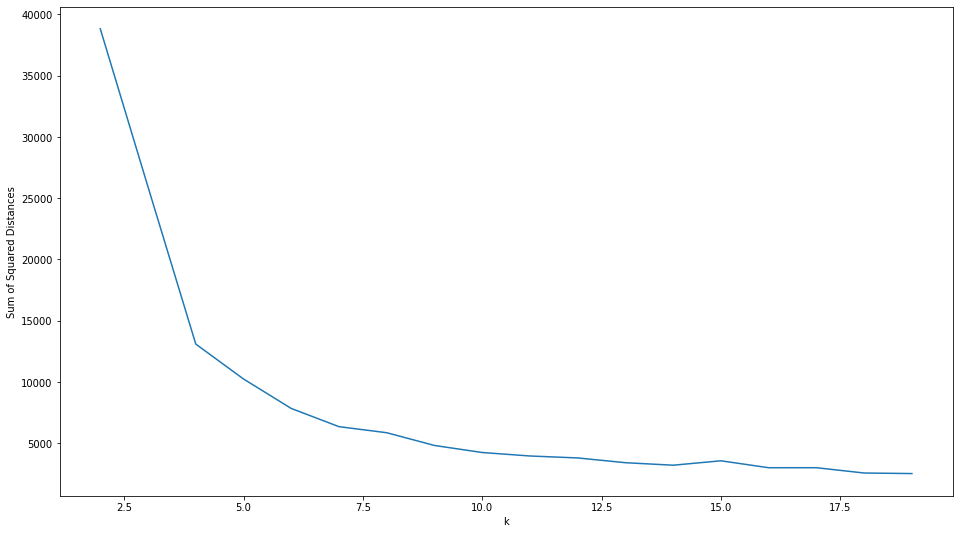

In [25]:
plt.plot(range(2,20), ssd)
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')

# seems like 5 clusters are appropriate

In [26]:
del coordinates_df['cluster']

In [27]:
range_n_clusters = range(2, 20)

X = np.array(coordinates_df)

for n_clusters in range_n_clusters:
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.5026467502002958
For n_clusters = 3 The average silhouette_score is : 0.5132745593074737
For n_clusters = 4 The average silhouette_score is : 0.566164215980916
For n_clusters = 5 The average silhouette_score is : 0.591191320195869
For n_clusters = 6 The average silhouette_score is : 0.5907779746624445
For n_clusters = 7 The average silhouette_score is : 0.5801221292146603
For n_clusters = 8 The average silhouette_score is : 0.574197565552152
For n_clusters = 9 The average silhouette_score is : 0.5913547539887604
For n_clusters = 10 The average silhouette_score is : 0.5456751570781648
For n_clusters = 11 The average silhouette_score is : 0.5950965589947061
For n_clusters = 12 The average silhouette_score is : 0.5628158455403909
For n_clusters = 13 The average silhouette_score is : 0.5572209434925244
For n_clusters = 14 The average silhouette_score is : 0.5677075306350605
For n_clusters = 15 The average silhouette_score is : 0.572056

In [28]:
clusterer = KMeans(n_clusters=11, random_state=10)
cluster_labels = clusterer.fit_predict(X)
centers = clusterer.cluster_centers_

In [29]:
gdf['Cluster Label'] = cluster_labels

In [30]:
centers_gdf = gpd.GeoDataFrame(centers, geometry=[Point(point) for point in centers])

In [ ]:
!pip install seaborn

In [31]:
import seaborn as sns
palette = sns.color_palette(None, 11).as_hex()

In [32]:
colors = palette

traces = []

for cluster_num in set(cluster_labels):
    
    sub_df = gdf[gdf['Cluster Label'] == cluster_num]
    
    trace = go.Scattermapbox(
    lon = sub_df['geometry'].x.values,
    lat = sub_df['geometry'].y.values,
    mode = 'markers',
    marker = go.scattermapbox.Marker(
    size = 5,
    color= colors[cluster_num],
    #symbol = 'star'
    ),
    text = sub_df['Place Name'] + "<br>" +
        "Cluster ID: " + str(cluster_num)
    )
    
    traces.append(trace)
    
cluster_center_trace = go.Scattermapbox(
    lon = centers_gdf['geometry'].x.values,
    lat = centers_gdf['geometry'].y.values,
    mode = 'markers',
    marker = go.scattermapbox.Marker(
    size = 7,
    color='red',
    #symbol = 'star'
    ),
    text = list(range(7))
    )

traces.append(cluster_center_trace)
    
fig = go.Figure(data = traces)

layout = go.Layout(
    autosize=True,
    hovermode='closest',
    width = 800, 
    height = 800,
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=51,
            lon=10
        ),
        pitch=0,
        zoom=5
    ),
)

fig.layout.update(layout)
                  
iplot(fig, filename="geomap_twitter_cluster")

In [ ]:
# germany_borders = gpd.read_file("Bundeslaender_2016_ew.shp")
# You can find it here: https://opendata-esri-de.opendata.arcgis.com/datasets/b8d0cc7735774bed8e6df1c5410394a4_0?geometry=-31.360%2C46.270%2C52.268%2C55.886

In [37]:
germany_borders = gpd.read_file("https://opendata.arcgis.com/datasets/b8d0cc7735774bed8e6df1c5410394a4_0.geojson")

In [ ]:
# Cannot have multiple geometry-like columns!
del gdf['Bounding Box']
del gdf['Tweet Coordinates']

In [56]:
# https://stackoverflow.com/questions/64200595/geopandas-overlay-intersection-returns-zero-rows THANK YOU!

# Multiple solutions: https://gis.stackexchange.com/questions/208546/check-if-a-point-falls-within-a-multipolygon-with-python

from geopandas.tools import overlay

gdf_list = []

for state_num in range(len(germany_borders)):
    
    # optional: check first if gdf.crs == sub_gdf.crs
    
    sub_gdf = gpd.GeoDataFrame(germany_borders.loc[state_num]).T
    sub_gdf['geometry'] = germany_borders.loc[state_num]['geometry']
    sub_gdf = sub_gdf.set_crs(epsg = 4326)
    
    intersected_points = overlay(gdf, sub_gdf, how="intersection")
    
    gdf_list.append(intersected_points)
    
    print("Current state: " + str(intersected_points['GEN'].unique()[0]) + ", Tweets sent: " + str(len(intersected_points)))

Current state: Schleswig-Holstein, Tweets sent: 320
Current state: Hamburg, Tweets sent: 11
Current state: Niedersachsen, Tweets sent: 1205
Current state: Bremen, Tweets sent: 107
Current state: Nordrhein-Westfalen, Tweets sent: 2130
Current state: Hessen, Tweets sent: 722
Current state: Rheinland-Pfalz, Tweets sent: 362
Current state: Baden-Württemberg, Tweets sent: 1066
Current state: Bayern, Tweets sent: 854
Current state: Saarland, Tweets sent: 89
Current state: Berlin, Tweets sent: 1690
Current state: Brandenburg, Tweets sent: 350
Current state: Mecklenburg-Vorpommern, Tweets sent: 239
Current state: Sachsen, Tweets sent: 397
Current state: Sachsen-Anhalt, Tweets sent: 220
Current state: Thüringen, Tweets sent: 180


In [59]:
len(gdf)

9951

In [83]:
merged_df = pd.concat(gdf_list)

In [84]:
tweets_count = merged_df.groupby('GEN').count()['Tweet ID'].sort_values(ascending=False)

In [85]:
tweets_count = pd.DataFrame(tweets_count)

In [86]:
states = ['Nordrhein-Westfalen', 'Berlin', 'Niedersachsen', 'Baden-Württemberg', 
          'Bayern', 'Hessen', 'Sachsen', 'Rheinland-Pfalz', 'Brandenburg',
         'Schleswig-Holstein', 'Mecklenburg-Vorpommern', 'Sachsen-Anhalt', 
          'Thüringen', 'Bremen', 'Saarland', 'Hamburg']

pop_data = [17947221, 3669491, 7993608, 11100394, 13124737, 6288080, 4071971, 
            4093903, 2521893, 2903773, 1608138, 2194782, 2133378, 681202, 986887, 1847253]

d = {'State': states, 'Pop': pop_data}
pop_df = pd.DataFrame(d)
pop_df = pop_df.set_index('State')

In [91]:
merged_pop_df = tweets_count.merge(pop_df, left_index=True, right_index=True)
merged_pop_df.head()

,Tweet ID,Pop
Nordrhein-Westfalen,2130,17947221
Berlin,1690,3669491
Niedersachsen,1205,7993608
Baden-Württemberg,1066,11100394
Bayern,854,13124737


In [111]:
from scipy import stats

X = np.log(merged_pop_df['Pop'])
y= np.log(merged_pop_df['Tweet ID'])

slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

print(slope, intercept, r_value, p_value, std_err)

1.076941506842333 -10.382026286432428 0.7547663624851767 0.0007264311473642486 0.25015848110294897


In [121]:
line = slope*X+intercept

trace_data = go.Scatter(
    x = X,
    y = y,
    mode = 'markers',
    marker = dict(symbol='circle'),
    text = list(merged_pop_df.index)
    # name='Equities',
    # hovertext=reshaped_df.iloc[:16,2].values
)

trace_line = go.Scatter(
                  x=X,
                  y=line,
                  mode='lines',
                  name='Fit'
                  )

annotation = go.Annotation(
                  x=13.5,
                  y=8,
                  text='$R^2 =' + str(round(r_value**2, 4)) + ', Y =' + str(round(slope, 4)) + 'X + ' + str(round(intercept,4)) + '$',
                  showarrow=False,
                  font=go.Font(size=12)
                  )

layout = go.Layout(
    title=go.layout.Title(
        text='Tweets and Population (state level)',
        xref='paper',
        x=0
    ),
    plot_bgcolor='rgb(229, 229, 229)',
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Log Population',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Log Tweets sent',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    annotations=[annotation]
)

data = [trace_data, trace_line]

fig = go.Figure(data=data, layout=layout)


iplot(fig, filename = 'tweets_pop')

How can the clusters and memberships you assigned before be meaningfully interpreted? How many Tweets (as percentage of all per state) were classified into the cluster with `cluster id = 8`? From which state does those cluster members most likely originate from? Confirm your assertion by looking at the map you created above.

In [157]:
grouped_df = pd.DataFrame(merged_df.groupby(['GEN','Cluster Label']).count()['Tweet ID'])
grouped_df = grouped_df.stack().to_frame().reset_index()
grouped_df['Cluster Label'] = grouped_df['Cluster Label'].astype(str)
grouped_df.columns = ['State', 'Cluster Label', 'Col Name', 'Count']
grouped_df.head()

,State,Cluster Label,Col Name,Count
0,Baden-Württemberg,0,Tweet ID,6
1,Baden-Württemberg,3,Tweet ID,140
2,Baden-Württemberg,8,Tweet ID,920
3,Bayern,0,Tweet ID,187
4,Bayern,3,Tweet ID,33


In [158]:
pd.crosstab(grouped_df['State'], grouped_df['Cluster Label'], values = grouped_df['Count'], aggfunc=np.sum, normalize='columns')

Cluster Label,0,1,10,2,3,4,5,6,7,8,9
State,,,,,,,,,,,
Baden-Württemberg,0.028037,0.000000,0.000000,0.000000,0.115226,0.000000,0.000000,0.000000,0.0,0.982906,0.000000
Bayern,0.873832,0.000000,0.000000,0.000000,0.027160,0.000000,0.000000,0.013559,1.0,0.017094,0.000000
Berlin,0.000000,0.752449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Brandenburg,0.000000,0.150045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.039039
Bremen,0.000000,0.000000,0.293151,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Hamburg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012528,0.000000,0.0,0.000000,0.000000
Hessen,0.009346,0.000000,0.000000,0.101852,0.547325,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Mecklenburg-Vorpommern,0.000000,0.028940,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.522523
Niedersachsen,0.000000,0.000000,0.671233,0.501852,0.000000,0.000000,0.675399,0.001695,0.0,0.000000,0.285285
